# Análisis logs Apache

Vamos a trabajar con un fichero de log generado por el proceso **Apache** en un sistema Linux. Este fichero, _proporcionado en la tarea_, se puede descargar también desde este enlace: [log apache](https://github.com/logpai/loghub/tree/master/Apache).

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/logpai/loghub/master/Apache/Apache_2k.log"
df = pd.read_csv(url, header=None)

df.head()

,0
0,[Sun Dec 04 04:47:44 2005] [notice] workerEnv....
1,[Sun Dec 04 04:47:44 2005] [error] mod_jk chil...
2,[Sun Dec 04 04:51:08 2005] [notice] jk2_init()...
3,[Sun Dec 04 04:51:09 2005] [notice] jk2_init()...
4,[Sun Dec 04 04:51:09 2005] [notice] jk2_init()...


# Descripción

Como se puede comprobar en la celda anterior, este dataset contiene diferentes entradas, cada una de ellas con un formato diferente a csv (por ello tan solo existe una columna, llamada `0`).

Como podemos observar, el patrón que sigue cada línea es:

- La fecha encerrada entre corchetes
- Tras un espacio, el log level del mensaje, de nuevo encerrado entre corchetes
- El resto es un mensaje descriptivo del evento ocurrido

# Task 1

En este primer ejercicio vamos a procesar el `DataFrame`, construyendo nuevas columnas a partir de la existente, utilizando _expresiones regulares_:

- timestamp: esta columna será el string correspondiente a la fecha, que está encerrada entre corchetes
- level: esta columna será el string correspondiente al log level del mensaje, que está encerrado entre corchetes
- message: se corresponde con el texto a continuación del carácter `]` después del log level

Una vez procesada la columna inicial y creadas las nuevas `timestamp`, `level` y `message`, la columna inicial `0` es redundante. Finalmente **la eliminaremos**. 

_**NOTA:** Existen varias alternativas para realizar este ejercicio. Una alternativa que puede resultar más cómoda, es procesar directamente la `pd.Series` correspondiente con la columna `0` del `pd.DataFrame` utilizando `str.extract`. Esta última función, si se utiliza un solo grupo en la expresión regular devuelve otra `pd.Series`. Si se utiliza más de un grupo en la expresión regular devuelve un `pd.DataFrame`. Si se usa esta alternativa, no hará falta eliminar la columna `0` como paso final, pero sí hará falta renombrar las columnas._

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> La primera fila del nuevo `DataFrame` debe contener la siguiente información (columnas `timestamp`, `level`, `message`, respectivamente):

- Sun Dec 04 04:47:44 2005
- notice
- workerEnv.init() ok /etc/httpd/conf/workers2....

</div>

In [2]:
import re


def extract_by_pattern(re_pattern: re.Pattern, text: str, pos: int) -> str:
    m = re_pattern.match(text)
    return m.group(pos)


re_pattern1 = re.compile("\[(.*\d)\]\s\[(\w*)\]\s(.*)")

df_processed = (
    pd.read_csv(url, header=None)
    .rename(columns={0: "text"})
    .assign(
        timestamp=lambda df: df["text"].map(lambda tx: extract_by_pattern(re_pattern=re_pattern1, text=tx, pos=1)),
        level=lambda df: df["text"].map(lambda tx: extract_by_pattern(re_pattern=re_pattern1, text=tx, pos=2)),
        message=lambda df: df["text"].map(lambda tx: extract_by_pattern(re_pattern=re_pattern1, text=tx, pos=3))
    )
)

del df_processed["text"]
df_processed.head()

,timestamp,level,message
0,Sun Dec 04 04:47:44 2005,notice,workerEnv.init() ok /etc/httpd/conf/workers2.p...
1,Sun Dec 04 04:47:44 2005,error,mod_jk child workerEnv in error state 6
2,Sun Dec 04 04:51:08 2005,notice,jk2_init() Found child 6725 in scoreboard slot 10
3,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6726 in scoreboard slot 8
4,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6728 in scoreboard slot 6


# Task 2

Transformar la columna `timestamp` en un tipo `datetime`, y asignarla como índice (siendo entonces de tipo `DatetimeIndex`).

In [3]:
import datetime

df_processed = (
    df_processed
    .assign(
        timestamp=lambda df: pd.to_datetime(df_processed["timestamp"], format="%a %b %d %H:%M:%S %Y")
    )
    .set_index("timestamp")
)

df_processed

,level,message
timestamp,,
2005-12-04 04:47:44,notice,workerEnv.init() ok /etc/httpd/conf/workers2.p...
2005-12-04 04:47:44,error,mod_jk child workerEnv in error state 6
2005-12-04 04:51:08,notice,jk2_init() Found child 6725 in scoreboard slot 10
2005-12-04 04:51:09,notice,jk2_init() Found child 6726 in scoreboard slot 8
2005-12-04 04:51:09,notice,jk2_init() Found child 6728 in scoreboard slot 6
...,...,...
2005-12-05 19:14:11,error,mod_jk child workerEnv in error state 6
2005-12-05 19:15:55,notice,jk2_init() Found child 6791 in scoreboard slot 8
2005-12-05 19:15:55,notice,jk2_init() Found child 6790 in scoreboard slot 7


# Task 3

Uno de los errores que genera **Apache** es un _forbidden access_. En este tipo de _logs_ se incluye el **path** al que se ha solicitado acceder y se ha denegado el acceso. Por ejemplo:

```
' [client 222.166.160.184] Directory index forbidden by rule: /var/www/html/'
```

Vamos a extraer el **path** existente en cada log de tipo _forbidden access_ (que contiene el texto **forbidden** en la columna `message`). ¿Cuántos paths únicos podemos encontrar?

In [4]:
d1 = df_processed["message"].str.contains("forbidden", regex=False)
d1.value_counts()

False    1968
True       32
Name: message, dtype: int64

In [5]:
re_pattern2 = re.compile("(.*forbidden.*\s)(/\w.*/)")

(
    df_processed.where(df_processed["message"].str.contains(re_pattern2, regex=True))
    .dropna()
    .assign(
        path=lambda df: df["message"].map(lambda tx: extract_by_pattern(re_pattern=re_pattern2, text=tx, pos=2)),
    )
    .groupby(["path"])
    .agg({
        "path": ["count"]
    })
)

/opt/conda/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,path
,count
path,
/var/www/html/,32


# Task 4

Vamos a analizar los mensajes en función del _log level_. Para ello, vamos a agrupar por la columna `level`, y vamos a calcular el % de mensajes que son únicos (atendiendo al campo `message`). Por ejemplo, si hay 1000 mensajes de level error, y de ellos solo hay 100 messages únicos, entonces hay un 10% de mensajes únicos.

In [6]:
df_processed_4 = (
    df_processed
    .groupby(["level"])
    .agg({
        "message": ["count", "nunique"]
    })
    .assign(
        messageUniquePercent=lambda df: df["message"]["nunique"] * 100 / df["message"]["count"]
    )
)

df_processed_4

message         messageUniquePercent
         count nunique                     
level                                      
error      595      50             8.403361
notice    1405     836            59.501779

# Task 5

Mostrar un gráfico de barras en el que en el eje X es el level (`notice` o `error`) y en el eje Y sea el conteo del número de mensajes de cada tipo.

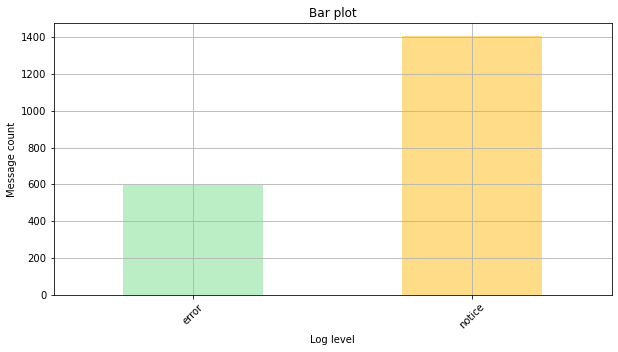

In [7]:
import matplotlib.pyplot as plt

df_processed_4["message"]["count"].plot(
    kind="bar",
    alpha=0.7,
    title="Bar plot",
    rot=45,
    grid=True,
    figsize=(10, 5),
    fontsize=10, 
    color=["#A0E8AF", "#FFCF56"])

plt.xlabel("Log level")
plt.ylabel("Message count");

# Task 6

Vamos a mostrar una gráfica de línea en la que el eje X sea la fecha (evolución temporal) y el eje Y sea el número de mensajes en cada hora. Es decir, el **eje X** se corresponde con los timestamps agregados por horas, y el **eje Y** con el número de logs generados para esa hora en concreto. Para ello, seguiremos la siguiente secuencia de pasos:

1. Resamplear el `DataFrame` por horas
2. Agregar contando por el número de entradas por cada hora
3. Usar el timestamp como eje X, y el número de entradas por hora para cada agrupación (hora) como eje Y

In [8]:
df_processed_6 = df_processed.resample("1H").agg({
    "message": ["count"]
})

df_processed_6.head()

,message
,count
timestamp,
2005-12-04 04:00:00,85
2005-12-04 05:00:00,50
2005-12-04 06:00:00,340
2005-12-04 07:00:00,105
2005-12-04 08:00:00,1


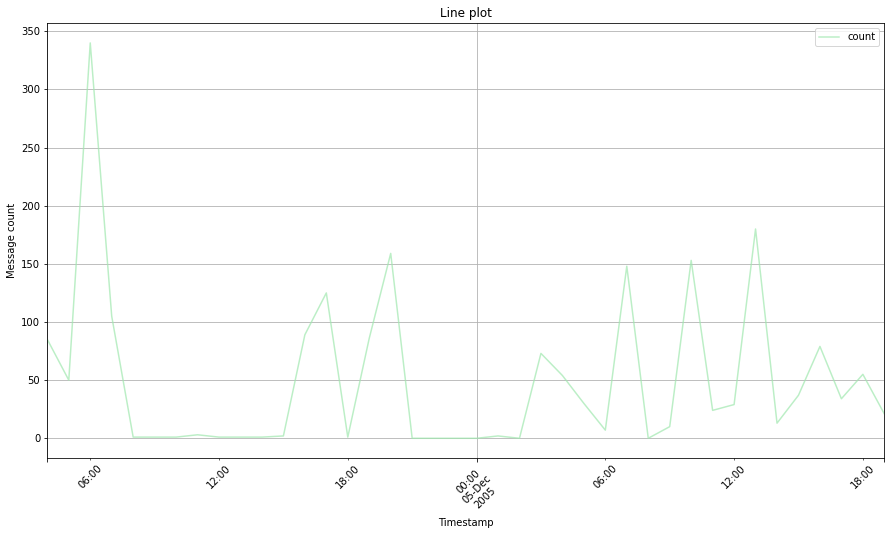

In [9]:
import matplotlib.pyplot as plt

df_processed_6["message"].plot(
    kind="line",
    alpha=0.7,
    title="Line plot",
    rot=45,
    grid=True,
    figsize=(15, 8),
    fontsize=10, 
    color=["#A0E8AF", "#FFCF56"])

plt.xlabel("Timestamp")
plt.ylabel("Message count");